# Цель занятия 1. Ознакомление с методом наименьших квадратов
# (МНК) как с эффективным способом построения регрессионной модели
# для задач прогнозирования, оценки статистической зависимости и анализа данных по выборкам. 

Задание на занятие 1 (ЛИНЕЙНАЯ РЕГРЕССИЯ). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

1а) подготовить для применения МНК две выборки значений нормально распределенных случайных величин. Параметры распределений, коэффициент взаимной корреляции величин, количество отсчетов
выборки выполнить задаваемыми. Провести последующие расчеты для
значений, согласованных с преподавателем;

In [3]:
# Параметры распределения
mean_x, mean_y = 0, 2  # Математические ожидания для x и y
std_x, std_y = 1, np.sqrt(6)  # Стандартные отклонения для x и y
corr = 0.75  # Коэффициент корреляции между x и y
n = 100  # Количество отсчетов в выборке

# Генерация выборок с заданной корреляцией
cov = corr * std_x * std_y  # Ковариация
cov_matrix = [[std_x**2, cov], [cov, std_y**2]]  # Матрица ковариации
x, y = np.random.multivariate_normal([mean_x, mean_y], cov_matrix, n).T  # Генерация данных

1б) рассчитать значения выборочных параметров распределения: математического ожидания и дисперсии. Сформулировать вывод по их отличию от заданных значений;

In [4]:
# Выборочные средние и дисперсии
sample_mean_x, sample_mean_y = np.mean(x), np.mean(y)
sample_var_x, sample_var_y = np.var(x, ddof=1), np.var(y, ddof=1)

print(f"Выборочное среднее x: {sample_mean_x}, y: {sample_mean_y}")
print(f"Выборочная дисперсия x: {sample_var_x}, y: {sample_var_y}")


Выборочное среднее x: 0.0014568857786904422, y: 1.891956421833146
Выборочная дисперсия x: 0.8864469722287248, y: 4.761849120390326


Гистограмма выборок

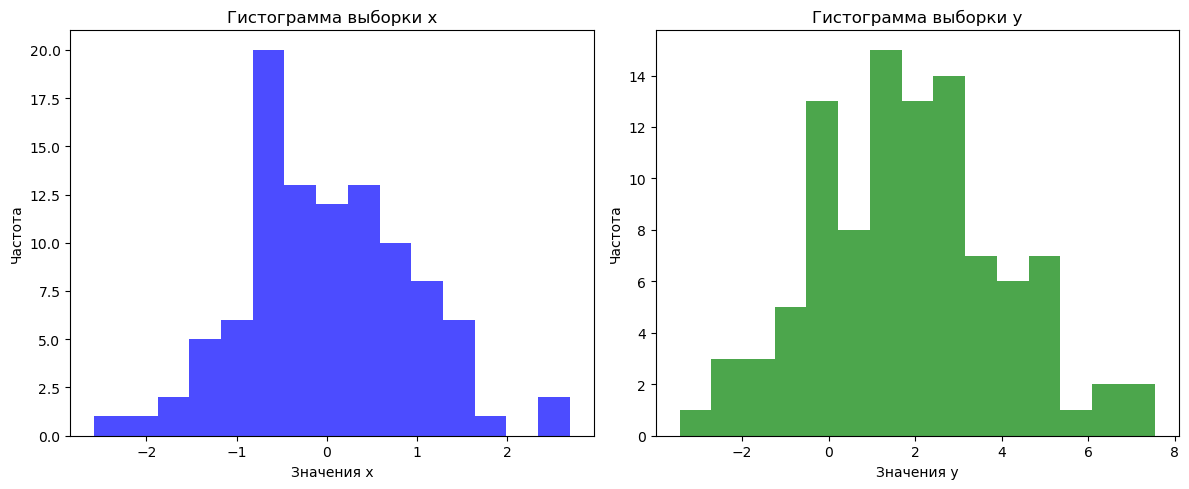

In [5]:
# Построение гистограмм для визуализации распределения данных
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x, bins=15, color='blue', alpha=0.7)
plt.title('Гистограмма выборки x')
plt.xlabel('Значения x')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(y, bins=15, color='green', alpha=0.7)
plt.title('Гистограмма выборки y')
plt.xlabel('Значения y')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


1в)  рассчитать по МНК коэффициенты регрессии для построения линии регрессии. Вывести в виде графика значения элементов выборок
с наложенной на них рассчитанной линией регрессии;

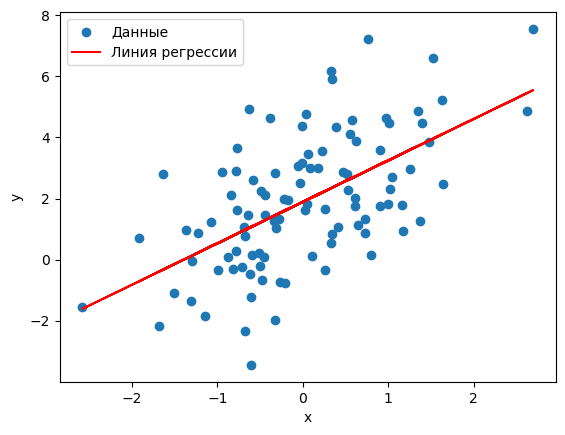

In [6]:
# Построение линии регрессии методом наименьших квадратов (МНК)
A = np.vstack([x, np.ones(n)]).T  # Матрица для МНК
m, c = np.linalg.lstsq(A, y, rcond=None)[0]  # Коэффициенты регрессии

# Визуализация данных и линии регрессии
plt.scatter(x, y, label='Данные')
plt.plot(x, m*x + c, 'r', label='Линия регрессии')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


1г) оценить значение коэффициента взаимной корреляции случайных величин по рассчитанным коэффициентам регрессии. Сформулировать вывод по отличию значения от заданного в пункте а);

In [7]:
# Оценка коэффициента корреляции Пирсона
corr_coef, _ = pearsonr(x, y)
print(f"Оцененный коэффициент корреляции: {corr_coef}")


Оцененный коэффициент корреляции: 0.5856272994662819


1д) оценить основные показатели качества МНК. Рассчитать сумму
остатков регрессионной модели. Вывести график остатков на экран;

Сумма остатков: -6.461498003318411e-14


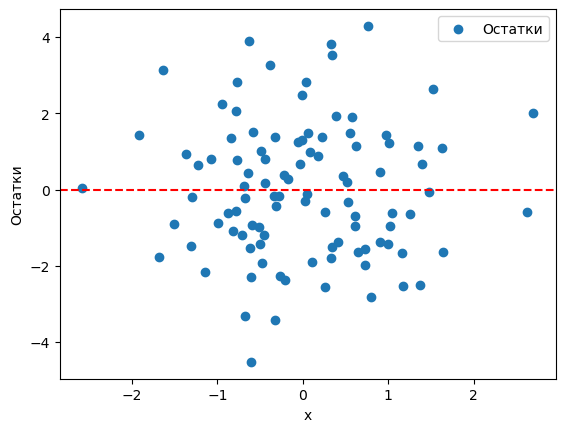

In [8]:
# Расчет остатков (разница между фактическими и предсказанными значениями)
residuals = y - (m*x + c)
print(f"Сумма остатков: {np.sum(residuals)}")

# Визуализация остатков
plt.scatter(x, residuals, label='Остатки')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Остатки')
plt.legend()
plt.show()


1е) изучить влияние количества отсчетов в выборках, значений параметров нормального распределения, а также отклонения распределения
от нормального на результат построения регрессионной зависимости. 

In [9]:
# Исследование влияния количества отсчетов на регрессию
n_values = [50, 100, 200, 500]  # Разные значения n
for n_val in n_values:
    x_val, y_val = np.random.multivariate_normal([mean_x, mean_y], cov_matrix, n_val).T
    A_val = np.vstack([x_val, np.ones(n_val)]).T
    m_val, c_val = np.linalg.lstsq(A_val, y_val, rcond=None)[0]
    print(f"n={n_val}, Коэффициент наклона: {m_val}, Свободный член: {c_val}")



n=50, Коэффициент наклона: 1.8242313307258062, Свободный член: 1.9030717051977133
n=100, Коэффициент наклона: 1.6132725317838663, Свободный член: 1.857478313881785
n=200, Коэффициент наклона: 1.9384354636323289, Свободный член: 2.1274879674054894
n=500, Коэффициент наклона: 2.008721686646015, Свободный член: 1.9500829558629607


# ЗАДАНИЕ 2: Применить МНК для прогнозирования значений зависимой переменной с задаваемым значением независимой переменной. Зависимость между переменными должна определяться случайным значением коэффициента взаимной корреляции в диапазоне [–1; 1]: 

2а) подготовить для применения МНК две выборки значений нормально распределенных случайных величин с задаваемыми параметрами распределений, количеством элементов и случайным значением
коэффициента взаимной корреляции из диапазона [–1; 1]. Провести последующие расчеты для значений, одобренных преподавателем; 

In [10]:
# Генерация выборок с случайным коэффициентом корреляции
corr = np.random.uniform(-1, 1)  # Случайный коэффициент корреляции
cov = corr * std_x * std_y  # Ковариация
cov_matrix = [[std_x**2, cov], [cov, std_y**2]]  # Матрица ковариации
x, y = np.random.multivariate_normal([mean_x, mean_y], cov_matrix, n).T  # Генерация данных


Гистограмма выборок

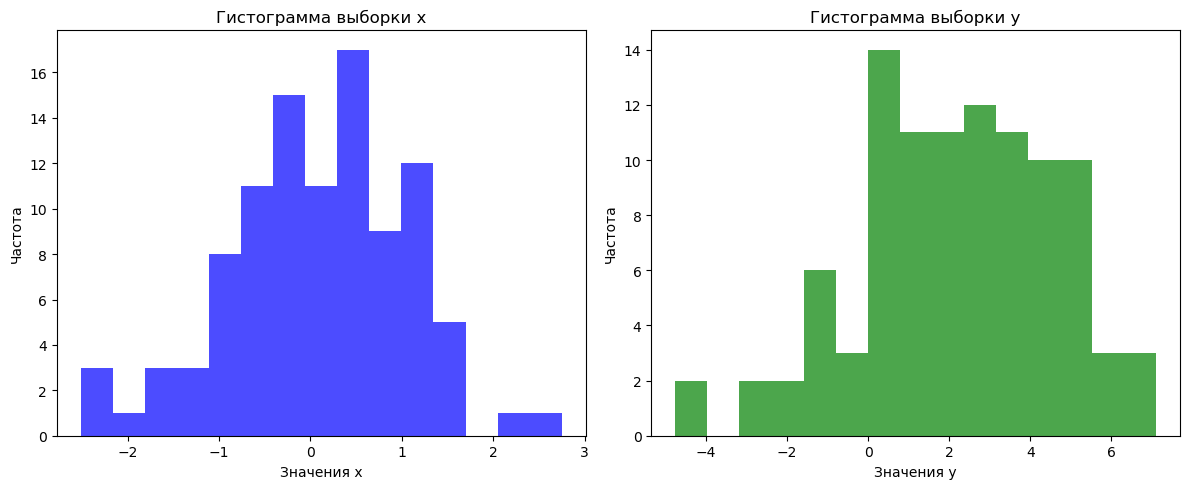

In [11]:
# Построение гистограмм для визуализации распределения данных
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x, bins=15, color='blue', alpha=0.7)
plt.title('Гистограмма выборки x')
plt.xlabel('Значения x')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(y, bins=15, color='green', alpha=0.7)
plt.title('Гистограмма выборки y')
plt.xlabel('Значения y')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


2б) оценить значения выборочных параметров распределений и коэффициента взаимной корреляции. Убедиться, что оцененные значения
с большой точностью соответствуют заданным; 

In [12]:
# Выборочные средние, дисперсии и коэффициент корреляции
sample_mean_x, sample_mean_y = np.mean(x), np.mean(y)
sample_var_x, sample_var_y = np.var(x, ddof=1), np.var(y, ddof=1)
corr_coef, _ = pearsonr(x, y)

print(f"Выборочное среднее x: {sample_mean_x}, y: {sample_mean_y}")
print(f"Выборочная дисперсия x: {sample_var_x}, y: {sample_var_y}")
print(f"Оцененный коэффициент корреляции: {corr_coef}")


Выборочное среднее x: 0.08816936015926752, y: 2.1699746957505486
Выборочная дисперсия x: 0.9523846878807509, y: 6.021223788842142
Оцененный коэффициент корреляции: 0.6622486422130768


2в) построить линию регрессии на основе значений выборочных параметров. Вывести в виде графика значения элементов выборок с наложенной на них рассчитанной линией регрессии; 


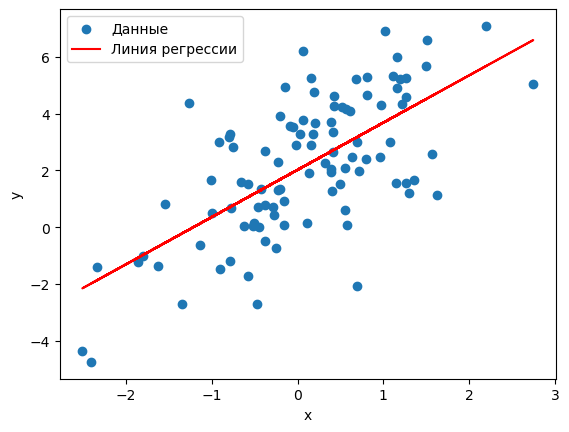

In [13]:
# Построение линии регрессии методом наименьших квадратов (МНК)
A = np.vstack([x, np.ones(n)]).T  # Матрица для МНК
m, c = np.linalg.lstsq(A, y, rcond=None)[0]  # Коэффициенты регрессии

# Визуализация данных и линии регрессии
plt.scatter(x, y, label='Данные')
plt.plot(x, m*x + c, 'r', label='Линия регрессии')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


2г) рассчитать прогнозируемое значение зависимой переменной для
нового значения независимой переменной;

In [14]:
# Прогнозирование значения y для нового значения x
x_new = 1.5  # Новое значение x
y_pred = m * x_new + c  # Прогнозируемое значение y
print(f"Прогнозируемое значение для x={x_new}: {y_pred}")


Прогнозируемое значение для x=1.5: 4.520905581225337


2д) рассчитать границы доверительного интервала значений прогнозируемой величины в абсолютных единицах и в процентах относительно прогнозируемого значения. При расчетах принять значение вероятности ложной тревоги равным 5 %; 

In [15]:
# Расчет доверительного интервала для прогнозируемого значения
alpha = 0.05  # Уровень значимости
t_critical = 1.96  # Критическое значение t-распределения для уровня значимости 5%
se = np.sqrt(np.sum(residuals**2) / (n - 2))  # Стандартная ошибка
margin = t_critical * se * np.sqrt(1 + 1/n + (x_new - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
ci_lower = y_pred - margin  # Нижняя граница доверительного интервала
ci_upper = y_pred + margin  # Верхняя граница доверительного интервала

print(f"Доверительный интервал: [{ci_lower}, {ci_upper}]")


Доверительный интервал: [0.9825333526137663, 8.059277809836908]


2е) построить зависимости значений границ доверительного интервала для указанного преподавателем набора значений независимой переменной.

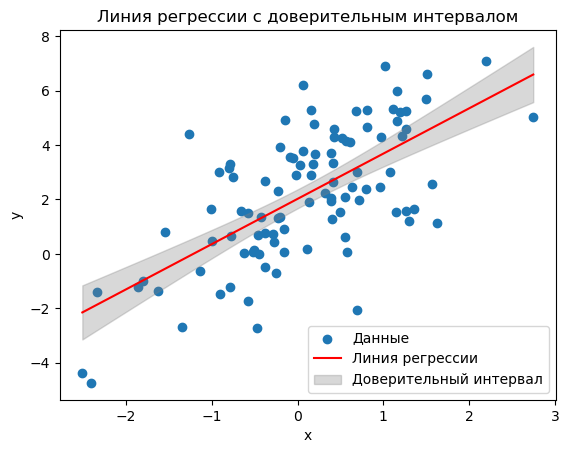

In [17]:
# Пункт е: Границы доверительного интервала

# Диапазон значений x для построения линии регрессии и доверительного интервала
x_range = np.linspace(np.min(x), np.max(x), 100)

# Линия регрессии
y_range = m * x_range + c

# Расчет стандартной ошибки регрессии
se = np.sqrt(np.sum(residuals**2) / (n - 2))

# Расчет доверительного интервала
margin = t_critical * se * np.sqrt(1/n + (x_range - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Визуализация данных, линии регрессии и доверительного интервала
plt.scatter(x, y, label='Данные')
plt.plot(x_range, y_range, 'r', label='Линия регрессии')
plt.fill_between(x_range, y_range - margin, y_range + margin, color='gray', alpha=0.3, label='Доверительный интервал')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Линия регрессии с доверительным интервалом')
plt.show()


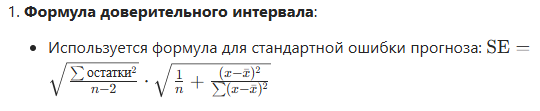

Общая структура кода
Код решает две задачи:

Задание 1: Имитация данных → Построение линейной регрессии → Анализ параметров.
Задание 2: Прогнозирование на новых данных → Расчет доверительных интервалов.

1а) Генерация данных

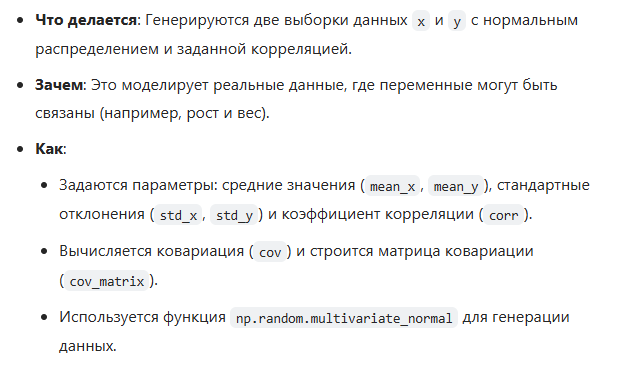


1б) Оценка параметров

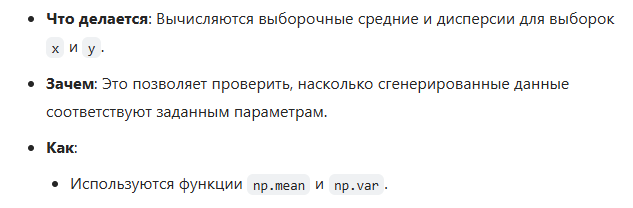

1в) МНК-регрессия

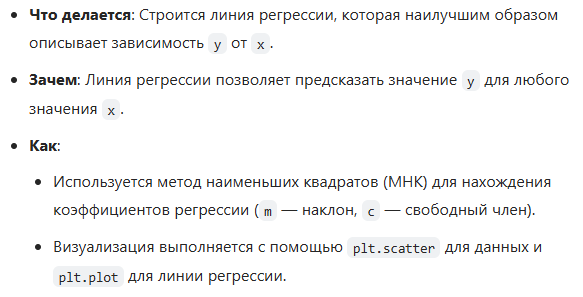

1г) Корреляция

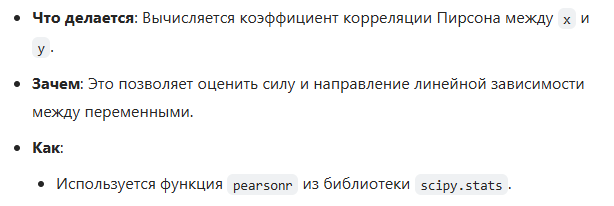

1д) Качество модели

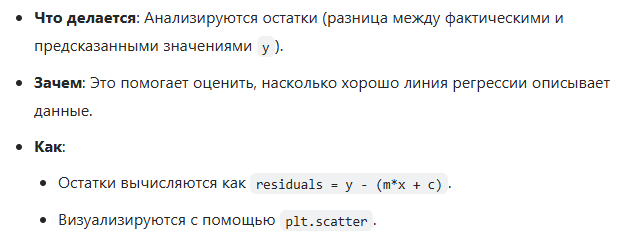

1е) Эксперимент с объемом выборки

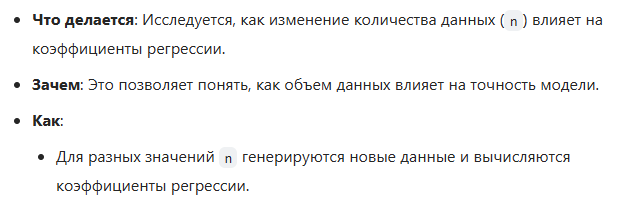

Задание 2: Прогнозирование

2а-2б) Новая генерация

для А

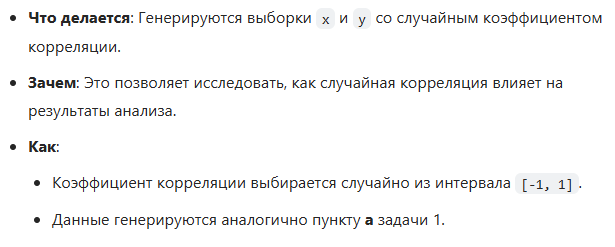

для Б
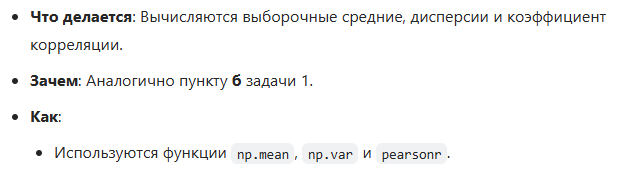

2в) Регрессия

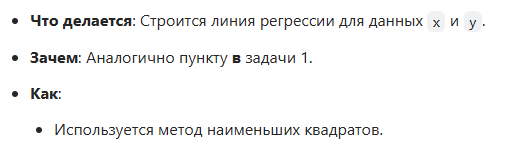

2г-2д) Прогноз и доверительный интервал

Г)
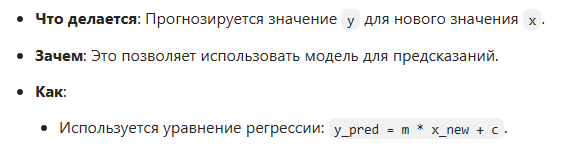

Д)

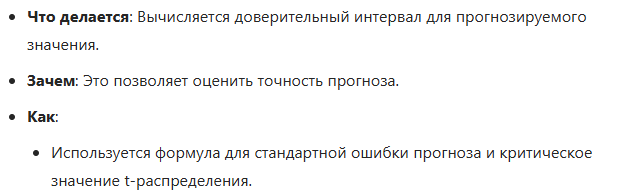

2е) Визуализация CI

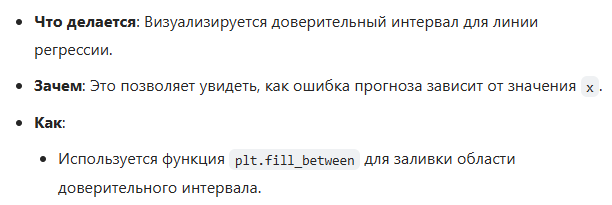